# Run These

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import joblib
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
from decimal import Decimal
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'd', 'h', '5min', or '15min'
def run_backtest(df, freq='d'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='d'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "/workspaces/Bitcoin-Systematic-Strategies/bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

# Import Data

In [6]:
df = pd.read_parquet("/workspaces/Bitcoin-Systematic-Strategies/modeling_backtesting/data/full_dataset_feature_engineering_v2.parquet", engine="pyarrow")
df.head()

# l = [col for col in df.columns]
# l

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2021-01-01 06:00:00,2.0,0.850000,0.0,0.0,0.0,0.15,0.0,-0.007795,219.4000,351.4194,...,0,0,0,0,0,0,-0.891,-0.891000,-0.111375,-0.111375
2021-01-01 07:00:00,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.003292,253.0935,336.2693,...,0,0,0,0,0,0,-0.594,-0.819720,-0.074250,-0.102465
2021-01-01 08:00:00,2.0,0.400000,0.0,0.0,0.0,0.50,0.0,-0.001883,284.9410,309.6284,...,1,1,1,0,0,0,-0.396,-0.754142,-0.049500,-0.094268
2021-01-01 09:00:00,2.0,-0.050000,0.0,0.0,0.0,0.40,0.0,-0.001648,326.5890,301.5680,...,1,1,1,0,0,0,-0.264,-0.693811,-0.033000,-0.086726
2021-01-01 10:00:00,3.0,0.766667,0.0,0.0,0.0,0.30,0.0,0.000118,351.1670,289.6874,...,1,1,1,0,0,0,-0.176,-0.638306,-0.022000,-0.079788


In [7]:
# df['return']=df['return_forward'].shift(1)

In [8]:
# Check for null values
total_nulls = df.isnull().sum().sum()
print(f'Total null values: {total_nulls}')

Total null values: 0


# Define X and y

In [19]:
# Top 30 features
features = [
# from RandomizedSearchCV v1
'topic_Other_last3',                      
'sma_5_20_diff_pct_chg',
'NER_us_last3',
'sma_50_200_diff_abs_chg',
'rsi_7_slope',
'10_band_width',
'source_The Currency Analytics_last3',
'adoption_absa_ewm_70h',
'atr_14',
'economy_absa_ewm_12h',
'regulation_absa_ewm_12h',
'trailing_stop_long_7',
'norm_price_change_7',
'atr_7',                               
'tanalysis_absa_ewm_70h',
'ema_50_200_diff',
'sma_20_50_diff_pct_chg',
'economy_absa_ewm_70h',
'upper_band_20',
'technology_absa_ewm_12h',
'sma_20_50_diff',
'ema_50_200_diff_pct_chg',              
'rsi_7_chg',
'upper_band_10',
'sma_20_50_diff_abs_chg',
'-di',
'20_band_width',
'ema_5_20_diff_abs_chg',
'rsi_ratio',
'reddit_average_sentiment_ewm_24h'



# from baseline v1
# 'source_CryptoPotato_last3',
# 'middle_band_20',
# 'NER_us_last3',
# 'trailing_stop_short_14',
# 'middle_band_10',
# 'source_Cryptopolitan_last24',
# '20_band_width',
# 'sma_50_200_diff_pct_chg',
# 'NER_el salvador_last24',
# 'sma_5_20_diff',
# 'year',
# 'lower_band_20',
# 'ema_5_20_diff_abs_chg',
# 'trailing_stop_short_7',
# 'macd_12_26',
# 'atr_7',
# 'upper_band_20',
# 'tanalysis_absa_ewm_12h',
# 'topic_Other_last3',
# 'atr_14',
# 'source_NewsBTC_last3',
# '10_band_width',
# 'sma_20_50_diff_abs_chg',
# 'news_count',
# 'rsi_14_slope',
# 'source_Coingape_last3',
# 'source_Cointelegraph_last3',
# 'norm_price_change_14',
# 'tanalysis_absa_ewm_70h',
# 'signal_line_9'       

]


In [20]:
target_col = 'return_forward'


X = df.drop(columns=['target', 'return_forward'])
X = X[features]

y = df[target_col]
X 

,topic_Other_last3,sma_5_20_diff_pct_chg,NER_us_last3,sma_50_200_diff_abs_chg,rsi_7_slope,10_band_width,source_The Currency Analytics_last3,adoption_absa_ewm_70h,atr_14,economy_absa_ewm_12h,...,sma_20_50_diff,ema_50_200_diff_pct_chg,rsi_7_chg,upper_band_10,sma_20_50_diff_abs_chg,-di,20_band_width,ema_5_20_diff_abs_chg,rsi_ratio,reddit_average_sentiment_ewm_24h
2021-01-01 06:00:00,0,0.164454,0,12.76625,2.743538,0.039453,0,0.150000,389.244944,0.000000,...,351.4194,0.005781,0.222184,29544.781706,-17.0119,17.085048,0.037161,93.228511,1.093717,-0.111375
2021-01-01 07:00:00,0,0.153571,0,4.71625,1.474075,0.030480,0,0.145775,386.199590,0.000000,...,336.2693,0.001595,-0.151845,29501.163293,-15.1501,15.989787,0.038478,-6.533001,1.009555,-0.102465
2021-01-01 08:00:00,0,0.125833,0,5.97550,1.650484,0.024058,0,0.155753,372.747477,0.000000,...,309.6284,0.002582,0.050101,29483.328440,-26.6409,15.383498,0.039799,11.141262,1.033077,-0.094268
2021-01-01 09:00:00,0,0.146164,0,-3.12520,-3.388682,0.022668,0,0.162633,370.156228,0.000000,...,301.5680,0.001226,-0.044214,29500.447220,-8.0604,16.214212,0.041148,-14.635095,1.008952,-0.086726
2021-01-01 10:00:00,0,0.075257,0,-5.37440,-0.765580,0.020372,0,0.166503,353.808641,0.000000,...,289.6874,0.000046,-0.043131,29496.559713,-11.8806,15.751713,0.042008,-28.058610,0.984842,-0.079788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,1,-0.493015,1,13.37500,-3.974927,0.027178,1,0.334773,594.021005,0.076394,...,312.8600,-0.010074,0.165671,95801.067876,20.7900,28.601038,0.030436,-89.019998,0.900321,0.015598
2024-12-31 20:00:00,1,-1.089007,1,12.32500,-2.410577,0.029955,1,0.338958,605.805219,0.067205,...,309.9000,0.001603,-0.221615,95876.395307,-2.9600,29.578700,0.030582,-197.813652,0.821252,0.014350
2024-12-31 21:00:00,1,6.895695,1,10.40500,1.084357,0.031291,1,0.337860,594.033418,0.092763,...,313.7300,-0.004116,0.195708,95898.271810,3.8300,28.010220,0.030364,-52.393518,0.900504,0.013202
2024-12-31 22:00:00,1,0.531977,1,-2.68000,-3.112560,0.034452,1,0.354400,585.602459,0.109261,...,310.7600,0.003336,-0.150227,95932.335823,-2.9700,27.713473,0.030744,-118.968881,0.844739,0.014441


# Split Data into Training (2021-2023) and Testing (2024)

In [21]:
train_mask = (df.index >= '2021-01-01') & (df.index < '2024-01-01')
test_mask = (df.index >= '2024-01-01')

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(26274, 30), y=(26274,)
Testing set shape: X=(8784, 30), y=(8784,)


# XGBoost Regressor Parameter

*   `objective='reg:squarederror'`: This specifies the learning task and the corresponding objective function. `'reg:squarederror'` indicates regression with squared error as the loss function. XGBoost will try to minimize the squared difference between the actual and predicted values.
*   `n_estimators=100`: This is the number of gradient boosted trees to build. It's equivalent to the number of boosting rounds. More estimators can lead to better performance but also increase training time and risk of overfitting.
*   `random_state=42`: This sets the seed for the random number generator. Using a fixed `random_state` ensures that results are reproducible across different runs, as aspects like feature subsampling (if used) will be consistent.
*   `enable_categorical=True` (Removed/Default is `False`): This flag enables experimental support for `pandas.Categorical` data types. Since the categorical features in this dataset are already numerically encoded (binary 0/1), this flag is not necessary. XGBoost handles numerical features by default.

# Initialize and Train XGBoost Regressor

## Option 1: Basic Model

In [22]:
# Initialize the XGBoost Regressor
# Parameters explained in the markdown cell above.
# Consider adding other parameters like learning_rate, max_depth, subsample, colsample_bytree etc. for tuning

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, reg_alpha=0.2, reg_lambda=2,
                           max_depth=7,
                           learning_rate=0.1,
                       
                           random_state=42)

# 200, 0.2, 2


# Train the model
xgb_reg.fit(X_train, y_train)

print("Simple model training complete.")

Simple model training complete.


## Option 2: Hyperparameter Tuning with TimeSeriesSplit
Use TimeSeriesSplit to find optimal hyperparameters based on cross-validation within the training period.

In [10]:
# Define parameter distributions for Randomized Search
param_dist = {
    'n_estimators': randint(100, 501),  # Discrete uniform distribution [100, 500]
    'max_depth': randint(3, 11),       # Discrete uniform distribution [3, 10]
    'learning_rate': uniform(0.005, 0.2 - 0.005), # Continuous uniform [0.005, 0.2) - adjusted for scipy.stats.uniform loc/scale
    'subsample': uniform(0.6, 1.0 - 0.6),         # Continuous uniform [0.6, 1.0)
    'colsample_bytree': uniform(0.6, 1.0 - 0.6),  # Continuous uniform [0.6, 1.0)
    'gamma': uniform(0, 1),                       # Continuous uniform [0, 1)
    'reg_alpha': uniform(0, 1),                   # Continuous uniform [0, 1)
    'reg_lambda': uniform(0, 2)                   # Continuous uniform [0, 2)
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5) # Adjust n_splits as needed

# Initialize the Regressor
# Using 'reg:squarederror'or 'reg:absoluteerror'
xgb_reg_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Number of iterations for random search
n_iterations = 300 # Adjust as needed based on computational resources

# Setup RandomizedSearchCV
# Use n_jobs=-1 to use all available CPU cores
# Use scoring='r2' or 'neg_mean_squared_error' or 'neg_mean_absolute_error'
random_search = RandomizedSearchCV(
    estimator=xgb_reg_base,
    param_distributions=param_dist,
    n_iter=n_iterations,
    scoring='r2', # Or 'neg_mean_squared_error' / 'neg_mean_absolute_error'
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42, # For reproducibility of the search itself
    refit=True      # Keep refit=True to get best_estimator_
)

# Fit the model
print(f"Starting Randomized Search with {n_iterations} iterations...")
random_search.fit(X_train, y_train)

# Print the results
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best R2 score on CV: {random_search.best_score_:.6f}") # Adjust metric name if scoring changes

# Get the best estimator
best_xgb_reg_random = random_search.best_estimator_
print(f"\nBest estimator from Randomized Search: {best_xgb_reg_random}")


Starting Randomized Search with 300 iterations...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits

Best parameters found: {'colsample_bytree': np.float64(0.9718116576991304), 'gamma': np.float64(0.8306194077877291), 'learning_rate': np.float64(0.19318024757996996), 'max_depth': 8, 'n_estimators': 472, 'reg_alpha': np.float64(0.7308674752036443), 'reg_lambda': np.float64(1.8766809136420757), 'subsample': np.float64(0.6724932264662641)}
Best R2 score on CV: -0.000406

Best estimator from Randomized Search: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.9718116576991304), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(0.8306194077877291), grow_policy=None,
             importance_type=None, interaction_constraints=None,
     

## Save and Load Model (Run this to get GridSearch results model)

In [ ]:

# Save RandomizedSearch
# joblib.dump(best_xgb_reg_random, 'xgb_reg_v2_model.pkl')
# print(f"Best model saved to: xgb_reg_v2_model.pkl")


# Load RandomizedSearch model
# loaded_model = joblib.load('xgb_reg_v2_model.pkl')
# print(f"Loaded model rand: {loaded_model}")

Loaded model rand: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.9718116576991304), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(0.8306194077877291), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.19318024757996996), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=472, n_jobs=None,
             num_parallel_tree=None, ...)


# Predictions (Pick the model for predictions)

**Note:** Ensure you are using the desired model (`xgb_reg` or `loaded_model` from RandomizedSearch ) for making predictions.

In [23]:
# Model for prediction
model = xgb_reg

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate Regressor

In [24]:
# Evaluate on Training Data
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print("--- Training Set Evaluation ---")
print(f"Mean Squared Error (MSE): {mse_train:.6f}")
print(f"Mean Absolute Error (MAE): {mae_train:.6f}")
print(f"R-squared (R2): {r2_train:.4f}")

# Evaluate on Test Data
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("\n--- Test Set Evaluation ---")
print(f"Mean Squared Error (MSE): {mse_test:.6f}")
print(f"Mean Absolute Error (MAE): {mae_test:.6f}")
print(f"R-squared (R2): {r2_test:.4f}")

--- Training Set Evaluation ---
Mean Squared Error (MSE): 0.000029
Mean Absolute Error (MAE): 0.003512
R-squared (R2): 0.4306

--- Test Set Evaluation ---
Mean Squared Error (MSE): 0.000032
Mean Absolute Error (MAE): 0.003369
R-squared (R2): -0.0483


In [25]:
print(f"Mean of y_train: {y_train.mean():.8f}")
print(f"Mean of y_test: {y_test.mean():.8f}")

Mean of y_train: 0.00003989
Mean of y_test: 0.00010471


# Visualize Prediction Results

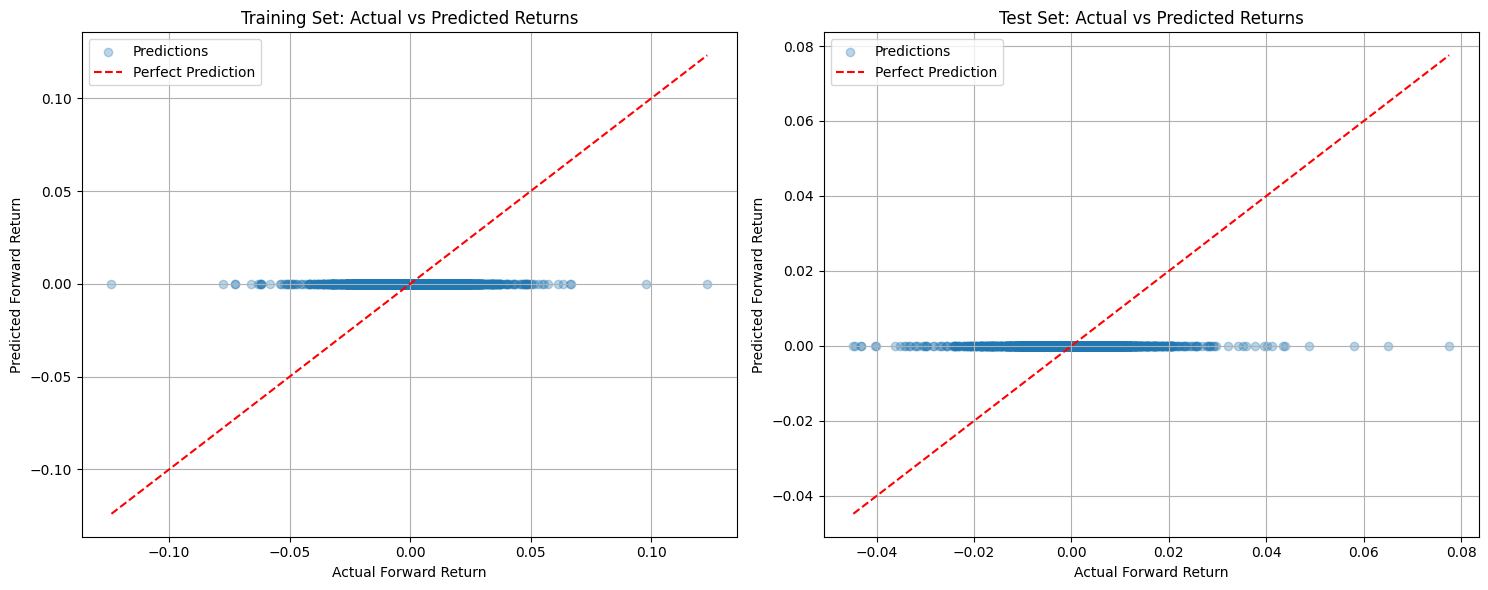

In [25]:
# 1. Predictions vs Actuals Scatter Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training Data
axes[0].scatter(y_train, y_pred_train, alpha=0.3, label='Predictions')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='red', label='Perfect Prediction')
axes[0].set_title('Training Set: Actual vs Predicted Returns')
axes[0].set_xlabel('Actual Forward Return')
axes[0].set_ylabel('Predicted Forward Return')
axes[0].legend()
axes[0].grid(True)

# Test Data
axes[1].scatter(y_test, y_pred_test, alpha=0.3, label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label='Perfect Prediction')
axes[1].set_title('Test Set: Actual vs Predicted Returns')
axes[1].set_xlabel('Actual Forward Return')
axes[1].set_ylabel('Predicted Forward Return')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

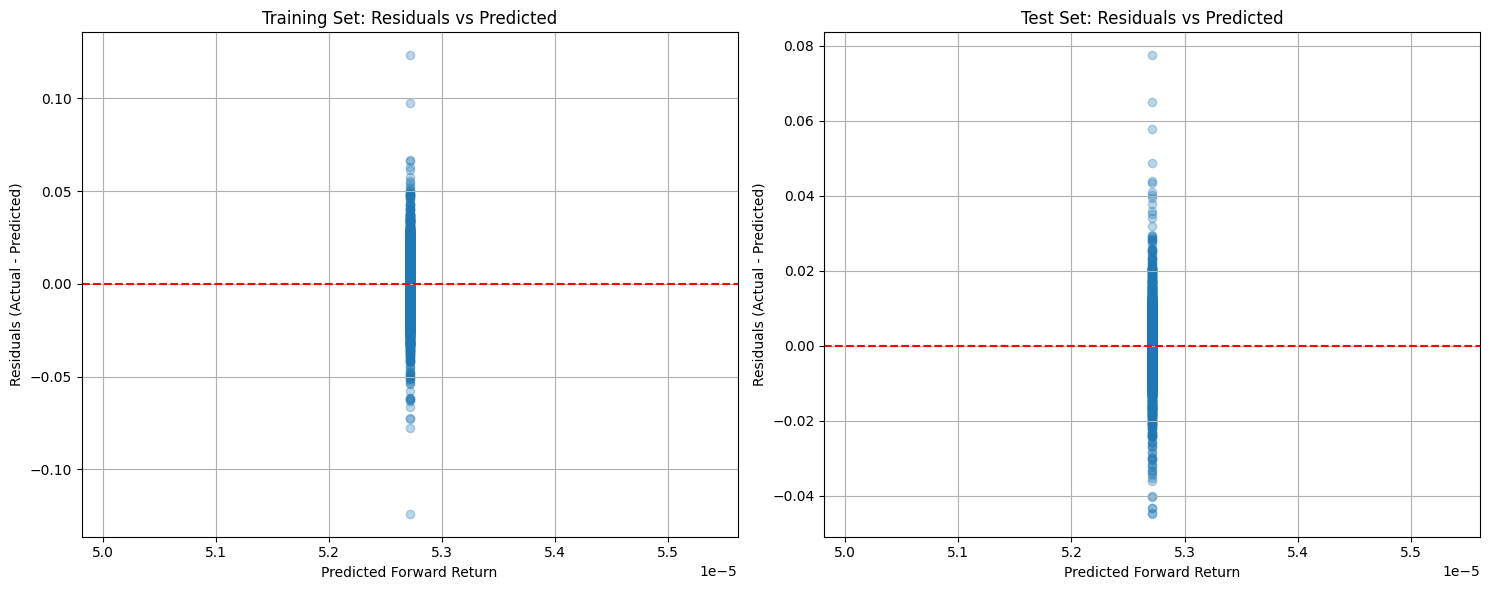

In [26]:
# 2. Residuals Plot
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training Residuals
axes[0].scatter(y_pred_train, residuals_train, alpha=0.3)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Training Set: Residuals vs Predicted')
axes[0].set_xlabel('Predicted Forward Return')
axes[0].set_ylabel('Residuals (Actual - Predicted)')
axes[0].grid(True)

# Test Residuals
axes[1].scatter(y_pred_test, residuals_test, alpha=0.3)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Test Set: Residuals vs Predicted')
axes[1].set_xlabel('Predicted Forward Return')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

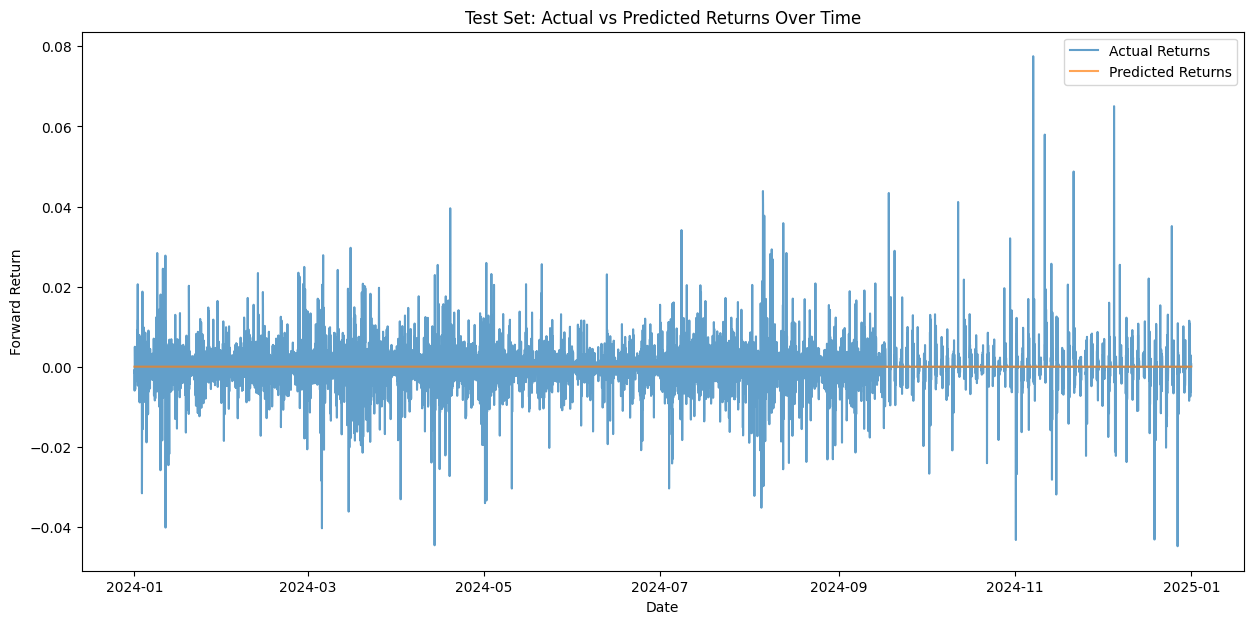

In [27]:
# 3. Predictions Over Time (Test Set)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test}, index=y_test.index)

plt.figure(figsize=(15, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual Returns', alpha=0.7)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Returns', alpha=0.7)
plt.title('Test Set: Actual vs Predicted Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Forward Return')
plt.legend()
plt.show()

# Feature Importance

Feature importance scores indicate how much each feature contributed to the model's predictions. Higher scores mean the feature was more influential.

**Note:** Ensure you are plotting importance for the model you used for prediction.

Top 30 features:
trailing_stop_short_14              0.0
NER_us_last3                        0.0
source_BeInCrypto_last3             0.0
topic_Other_last3                   0.0
20_band_width                       0.0
source_NewsBTC_last3                0.0
source_CoinPedia_last3              0.0
trailing_stop_short_7               0.0
NER_coinbase_last24                 0.0
10_band_width                       0.0
lower_band_20                       0.0
rsi_14_slope                        0.0
adx_slope                           0.0
atr_7                               0.0
trailing_stop_long_14               0.0
middle_band_10                      0.0
sma_5_20_diff                       0.0
rsi_7_slope                         0.0
reddit_total_sentiment_ewm_24h      0.0
source_AMBCrypto_last3              0.0
sma_50_200_diff_pct_chg             0.0
source_Cryptopolitan_last3          0.0
signal_line_9                       0.0
topic_others_last3                  0.0
lower_band_10          

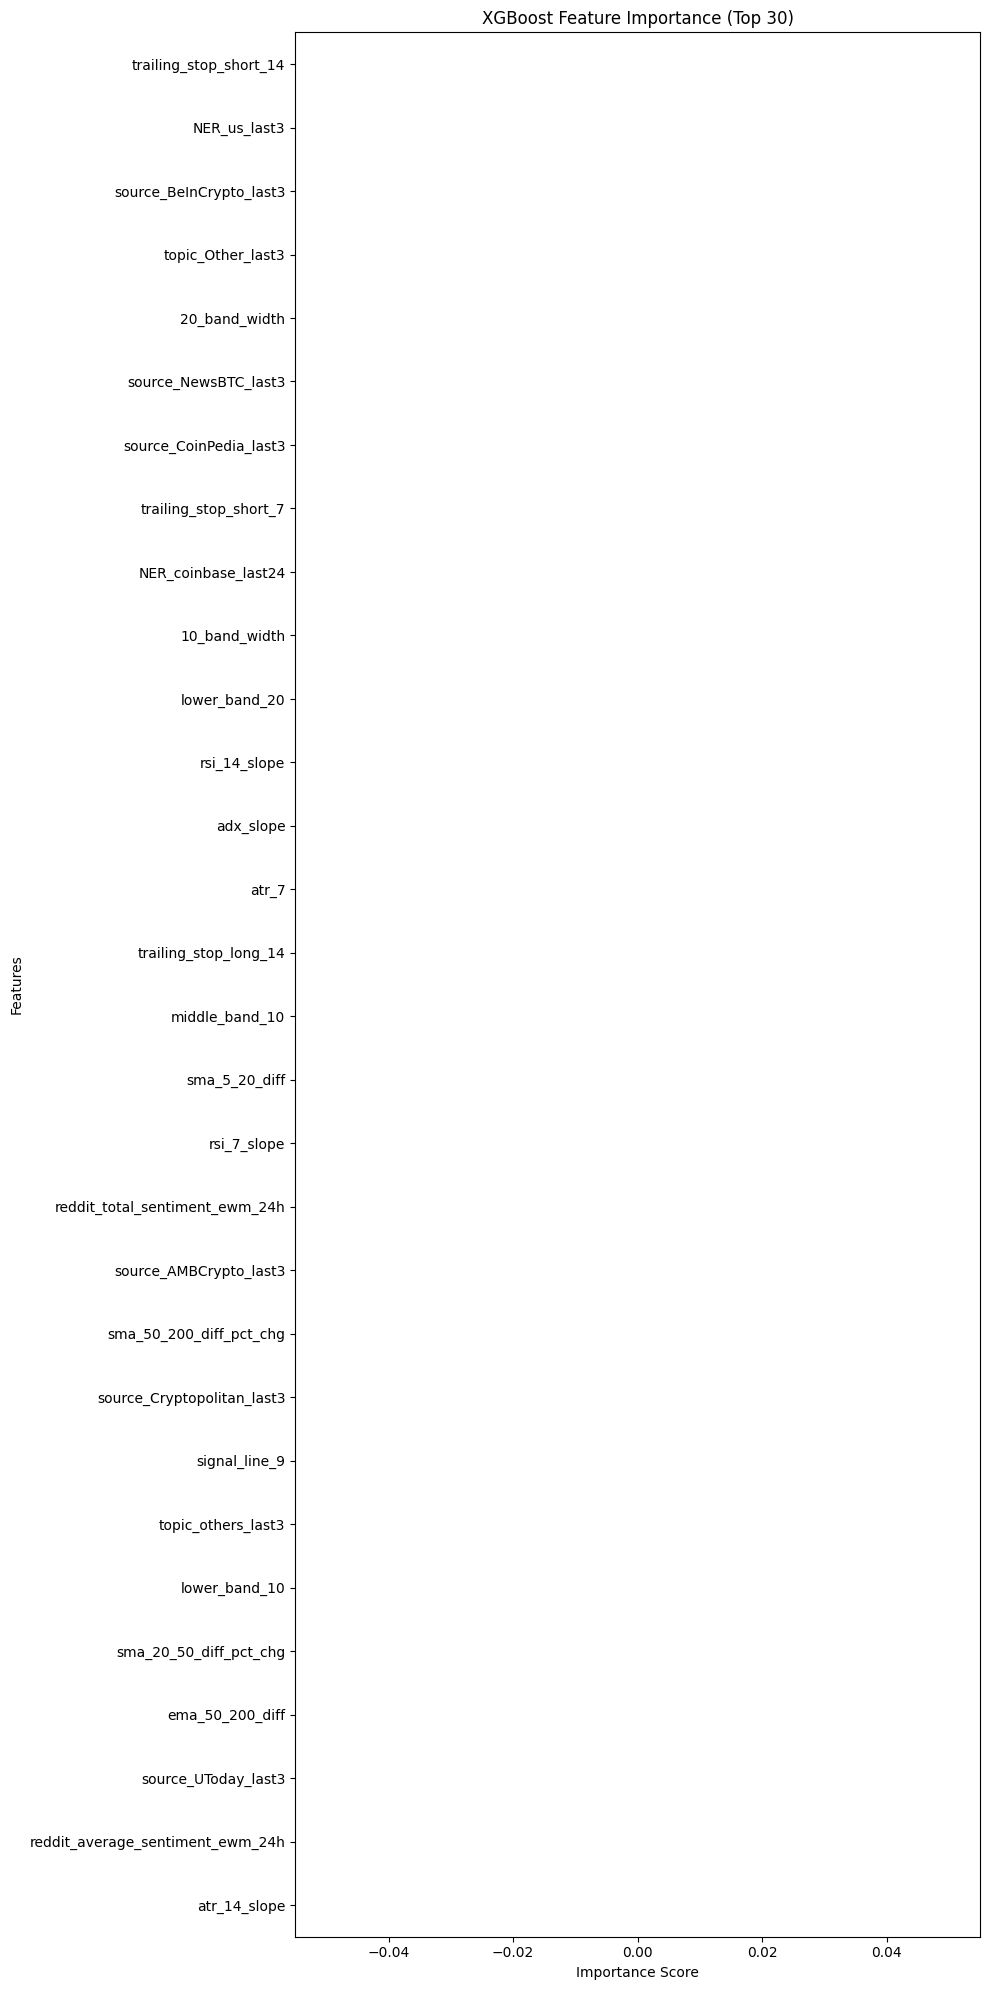

In [28]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# print top 30 features
print("Top 30 features:")
print(feature_importances.head(30))

plt.figure(figsize=(10, 20)) # Adjust figure size as needed
sns.barplot(x=feature_importances.head(30), y=feature_importances.head(30).index) # Display top 30
plt.title('XGBoost Feature Importance (Top 30)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# Backtest

In [132]:
y_pred_test

array([-0.00065755, -0.00025262,  0.00052719, ..., -0.00271003,
       -0.00162118, -0.00068906], shape=(8784,), dtype=float32)

In [133]:
df[test_mask]['target'].value_counts()

# 1 2862
# -1 2648
# 0 3274

target
1    3274
2    2862
0    2648
Name: count, dtype: int64

In [26]:
val = 1

signal = pd.DataFrame(y_pred_test, index=X_test.index, columns=['pred_ret'])
signal['signal'] = np.where(signal['pred_ret']*val > 0.001, 1, 
                            np.where(signal['pred_ret']*val < -0.001, -1, 0)) 
# signal['signal'] = signal['signal'].ewm(span=3).mean()


print(signal['signal'].value_counts())

signal

signal
 0    5513
-1    1705
 1    1566
Name: count, dtype: int64


,pred_ret,signal
2024-01-01 00:00:00,-0.000520,0
2024-01-01 01:00:00,0.000128,0
2024-01-01 02:00:00,0.000040,0
2024-01-01 03:00:00,-0.001047,-1
2024-01-01 04:00:00,-0.001375,-1
...,...,...
2024-12-31 19:00:00,-0.000085,0
2024-12-31 20:00:00,0.000048,0
2024-12-31 21:00:00,-0.000005,0
2024-12-31 22:00:00,0.000378,0


Overall Annual Return: 152.31%
Overall Annual Sharpe Ratio: 2.6589
Maximum Drawdown: -20.64 %
Alpha: 1.5932
Beta: 0.0458

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.523094    0.374415     0.045782      0.952926        2.65893


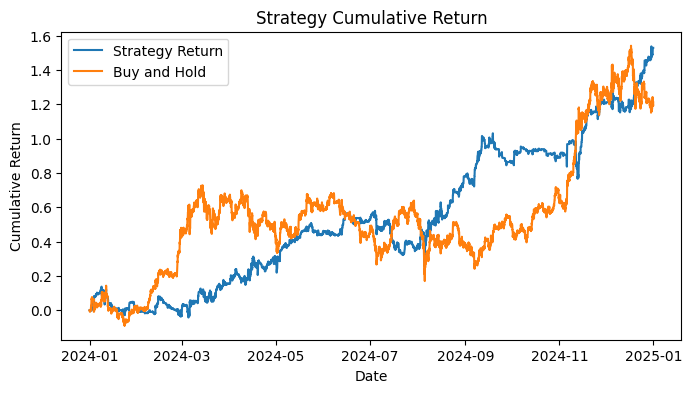

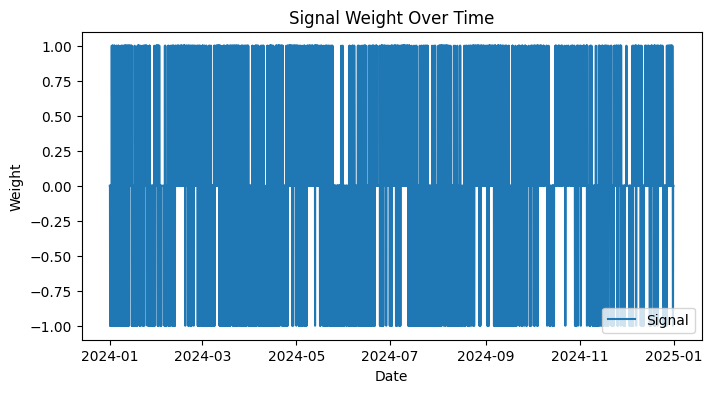

In [27]:
run_backtest(signal, freq='h')

# Classification Evaluation (Con_Mat)

Length of true signals: 8784
Length of predicted signals: 8784


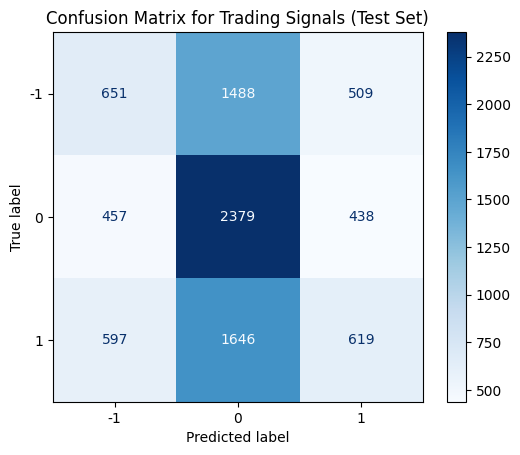


Classification Report:
              precision    recall  f1-score   support

  Short (-1)       0.38      0.25      0.30      2648
    Hold (0)       0.43      0.73      0.54      3274
    Long (1)       0.40      0.22      0.28      2862

    accuracy                           0.42      8784
   macro avg       0.40      0.40      0.37      8784
weighted avg       0.40      0.42      0.38      8784


Overall Accuracy: 0.42


In [184]:

# Generate Actual Signals from y_test
threshold = 0.001
y_true_signal = np.where(y_test > threshold, 1,
                         np.where(y_test < -threshold, -1, 0))


# Get the predicted signals generated previously
y_pred_signal = signal['signal'].values 

# Ensure both arrays have the same length (they should if derived from y_test and y_pred_test)
print(f"Length of true signals: {len(y_true_signal)}")
print(f"Length of predicted signals: {len(y_pred_signal)}")

# Calculate Confusion Matrix
labels = [-1, 0, 1] # Define the order of labels
cm = confusion_matrix(y_true_signal, y_pred_signal, labels=labels)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Trading Signals (Test Set)')
plt.show()

# Calculate and Print Classification Metrics
print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might not be predicted
print(classification_report(y_true_signal, y_pred_signal, labels=labels, target_names=['Short (-1)', 'Hold (0)', 'Long (1)'], zero_division=0))

# Calculate overall accuracy
accuracy = accuracy_score(y_true_signal, y_pred_signal)
print(f"\nOverall Accuracy: {accuracy:.2f}")



# Store results for easier comparison later
evaluation_results = {
    'confusion_matrix': cm,
    'classification_report': classification_report(y_true_signal, y_pred_signal, labels=labels, target_names=['Short (-1)', 'Hold (0)', 'Long (1)'], zero_division=0, output_dict=True),
    'accuracy': accuracy
}

# You can print evaluation_results or save it if needed
# print(evaluation_results)